# $SAT$ SOLVER

#### By Rishav Gupta(BMC202145) , Srijan Chakraborty(BMC202180) , Ankit Gayen(BMC202116)

## $SAT$: Satisfiability Problem
1. SAT is a well known and widely used problem in computer science. Its
aim is to identify the input combinations for which the given expression is
satisfied.
2. In worst case, it is required to check all $2^𝑛$ input combinations, for input
size of n.
3. A SAT problem consist of several constraints all of which needs to be
satisfied.
4. For a given $SAT$ instance in $CNF$ form we will find the quantum circuit which will siimulate the oracle for this $SAT$ instance in Grover's Search to amplify those inputs which satisfies the given instance.
5. And finally we will output one satisfying assignment to this $SAT$ instance.




## Construction of the oracle for Grover's Search
1. First we will do the $OR$'s for all clauses then finally we will do the $AND$ of all of these outputs for these clauses.
2. Then we will use this to construct the oracle for grovers which flips the sign if it is satisfiable.
3. We will use $m+n+2$ qubits for implementing. 
4. The $0^{th}$ qubit is used to change phase depending on the value of $SAT$.
5. The next $n$ qubits are used to simulate the $n$ inputs.
6. The last quibit with index $n+m+1$ is just another auxillary quibit which we use to double the search space to increase acurracy.
7. The rest $m$ qubits are workspaces for the oracle and are used to store the $OR$'s for clauses whose $AND$ is used to add a phase flip.
4. Following are implementation of some basic gates which we will use as a motivation for constructing the oracle.

### Initial Imports 

In [954]:
from qiskit import QuantumCircuit, transpile, Aer,execute
import math
from qiskit.extensions import UnitaryGate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
backend=Aer.get_backend('qasm_simulator')

## NOT gate

The NOT gate flips the value of a bit and, as was mentioned before, an X gate can be considered a NOT gate. The truth table for a NOT gate looks like this:

| Input | Output |
| --- | --- |
| 1 | 0 |
| 0 | 1 |

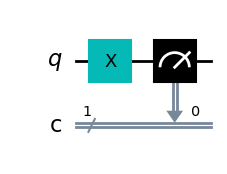

In [955]:
not_gate=QuantumCircuit(1,1) # Create a quantum circuit with 1 qubit and 1 classical bit
not_gate.x(0)
not_gate.measure(0,0)
not_gate.draw(output='mpl')

## AND gate

The output of an AND is true if and only if both inputs are true. The truth table for an AND Gate looks like this:

| A (Input) | B (Input) | Output |
| --- | --- | --- |
| 0 | 0 | 0 | 
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

With a Toffoli gate, we can get the result of an AND gate by interpreting the two control bits as the input bits and the target bit as the output bit.

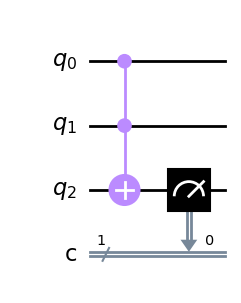

In [956]:
and_gate=QuantumCircuit(3,1) # Create a quantum circuit with 3 qubits and 1 classical bit
and_gate.ccx(0,1,2)
and_gate.measure(2,0)
and_gate.draw(output='mpl')

## OR gate

An OR gate returns true if at least one of the input gates is true.
The truth table for an OR Gate looks like this:

| A (Input) | B (Input) | Output |
| --- | --- | --- |
| 0 | 0 | 0 | 
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 1 |

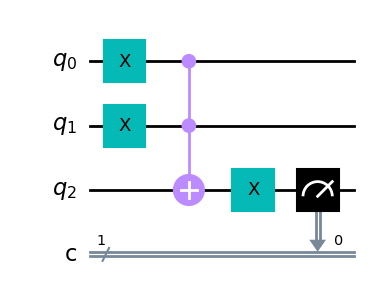

In [957]:
or_gate=QuantumCircuit(3,1) # Create a quantum circuit with 3 qubits and 1 classical bit
or_gate.x(0)
or_gate.x(1)
or_gate.ccx(0,1,2)
or_gate.x(2)
or_gate.measure(2,0)
or_gate.draw(output='mpl')

### XOR gate

A XOR gate returns true if both of the inputs are not equal.
The truth table for an XOR Gate looks like this:

| A (Input) | B (Input) | Output |
| --- | --- | --- |
| 0 | 0 | 0 | 
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |


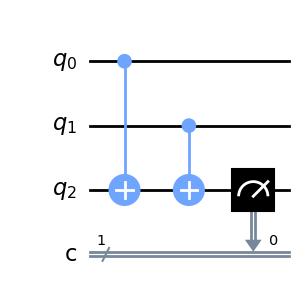

In [958]:
xor_gate=QuantumCircuit(3,1) # Create a quantum circuit with 3 qubits and 1 classical bit
xor_gate.cx(0,2)
xor_gate.cx(1,2)
xor_gate.measure(2,0)
xor_gate.draw(output='mpl')

## General $OR$
Here we are just using Demorgan's Law to construct general $OR$ gate using general $AND$ gate which is just the multiple controlled not gate.

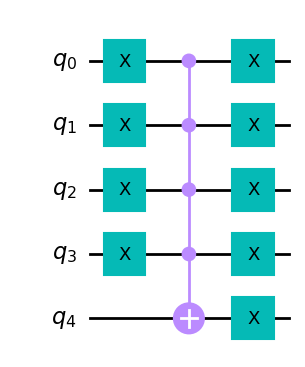

In [959]:
def or_gate_general(n):
    org=QuantumCircuit(n+1)
    for i in range(0,n):
        org.x(i)
    org.mcx(control_qubits=[j for j in range(0,n)],target_qubit=n)
    for i in range(0,n):
        org.x(i)
    org.x(n)
    return org
#Here quibit with index n will be initiated to 0 and outputs the corresponding answer
sample_or=or_gate_general(4)
sample_or.draw(output='mpl')

## General $AND$

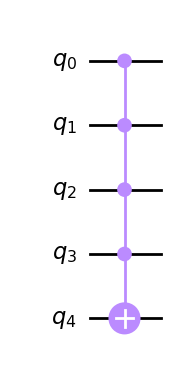

In [960]:
def and_gate_general(n):
    andg=QuantumCircuit(n+1)
    andg.mcx(control_qubits=[j for j in range(0,n)],target_qubit=n)
    return andg
#Here quibit with index n is initiated with index 0 and outputs the corresponding answer after application of this gate
sample_and=and_gate_general(4)
sample_and.draw(output='mpl')

## Parsing the input string

Input Format: 


$1$. Indexing of the variables start at 1. We assume the variables are input in the format "xi"(representing the $i$th variable $x_i$) with "|" representing the  logical OR gate. Each clause is delimited by the "&" symbol which stands for the logical AND gate. 

$2$. There may or may not be spaces between the variables. A negated variable is reprsented with a '-' symbol immediately before it.
Brackets may or amy not be entered to separate clauses. 

Example : (x1 | -x2 | x3 | -x4) & (x1 | x3) $\rightarrow$ [[1, -2, 3, -4], [1, 3]]



In [961]:
def parse(s):
    lst=[]
    lst1=[]
    for i in range(0,len(s)):
        if s[i]=='x':
            if s[i-1]=='-':

                lst1.append(int("-"+s[i+1]))
            else:
                lst1.append(int(s[i+1]))

        elif s[i]=='&':
            lst.append(lst1)
            lst1=[]

        else:
            pass
    lst.append(lst1)
    return lst

#print(parse("(x1 | -x2 | x3 |-x4)&(x1 | x3)")) returns [[1, -2, 3, -4], [0, 3]]

## Make an Oracle for $SAT$ instance. 

1. For every clause, we use the generalized $OR$ gate, and finally take their $AND$.

2. The $0^{th}$ qubit  is to add the phase of $(-1)^{f(x)}$ w.r.t the final $AND$ (Here $f$ is the $SAT$ instance). Qubits $1$ to $n$ are inputs, and qubits $n+1, n+2, \ldots $ are auxillary for the $OR$ gates(clauses).

In [962]:
def convert_to_oracle(s):
    n=-1
    l=parse(s)
    for l1 in l:
        for i in l1:
            n=max(n,abs(i))
    

    sat=QuantumCircuit(n+len(l)+1)
    sat.x(0)
    sat.h(0)
    ori=n+1
    for k in range(len(l)):
        m=len(l[k])
        li=[]
        sampleor=or_gate_general(m)
        for i in l[k]:
            if(i<0):
                sat.x(-1*i)
            li.append(abs(i))
        li.append(ori)
        #print (len(li))
        #print(m+1)
        sat.compose(sampleor,li,inplace=True)
        for i in l[k]:
            if(i<0):
               sat.x(-1*i)
        ori+=1
    andgate=0
    land=[]
    for i in range (n+1,ori):
        land.append(i)
    land.append(andgate)
    sampleand=and_gate_general(ori-n-1)
    sat.compose(sampleand,land,inplace=True)
    #for i in range(n+1,n+len(l)+1):
     #   sat.reset(i)
    return sat
#example_inst=convert_to_oracle("(-x1 | -x3 )&(x1 | x4)")
#example_inst.measure(0,0)
#example_inst.draw('mpl')


## Uncompute

Now we need to reset the auxiliary qubits, since we need to repeat the grover oracle multiple times and reuse these qubits.

In [964]:
def uncompute(s):
    n=-1
    l=parse(s)
    for l1 in l:
        for i in l1:
            n=max(n,abs(i))
    

    sat=QuantumCircuit(n+len(l)+1)
    ori=n+len(l)
    for k in range(len(l)-1,-1,-1):
        m=len(l[k])
        li=[]
        sampleor=or_gate_general(m)
        for i in l[k]:
            if(i<0):
                sat.x(-1*i)
            li.append(abs(i))
        li.append(ori)
        #print (len(li))
        #print(m+1)
        sat.compose(sampleor,li,inplace=True)
        for i in l[k]:
            if(i<0):
               sat.x(-1*i)
        ori-=1
    #andgate=0
    #land=[]
    #for i in range (n+1,ori):
    #    land.append(i)
    #land.append(andgate)
    #sampleand=and_gate_general(ori-n-1)
    #sat.compose(sampleand,land,inplace=True)
    sat.h(0)
    sat.x(0)
    #for i in range(n+1,n+len(l)+1):
     #   sat.reset(i)
    return sat
#example_inst=convert_to_oracle("(-x1 | -x3 )&(x1 | x4)")
#example_inst.measure(0,0)
#example_inst.draw('mpl')


## Difussion Operator
The follwing is the diffusion operator which is used in Grover's algorithm.
- The below function takes input $n$ (the number of variables in the instance of $SAT$) and returns a Quantum Circuit for the diffusion operator with n qubits.

In [965]:
def grover_diffusion_operator(n):
    grover_diffusion = QuantumCircuit(n)

    # Apply Hadamard gates to all qubits
    grover_diffusion.h(range(n))

    cbit=[]
    for i in range(1,n):
        cbit.append(n-i)
        grover_diffusion.x(i)
        
    grover_diffusion.x(0)
    grover_diffusion.h(0)
    
    grover_diffusion.mcx(control_qubits=cbit,target_qubit=0)
    for i in range(1,n):
        grover_diffusion.x(i)
        
    grover_diffusion.h(0)
    grover_diffusion.x(0)
        

    

    # Apply Hadamard gates to all qubits
    grover_diffusion.h(range(n))

    return grover_diffusion


## IQFT

The below function takes input $n$ and returns the inverse quantum fourier transform circuit on $n$ qubits.

In [966]:
def iqft(n):
    iqf=QuantumCircuit(n)
    for i in range(n-1,-1,-1):
        iqf.h(i)# Here we are adding the Hadamard operations which are needed in inverse transform
        for j in range(i-1,-1,-1):
            iqf.cu(theta=0,gamma=0,phi=-2 * math.pi / 2**(i-j+1),lam=0,control_qubit= i,target_qubit= j)#In this we are adding all controlled rotations we need to add in the inverse quantum fourier circuit
    return iqf


## Grover Oracle
- The below function takes input a $SAT$ instance as a string and returns a quantum circuit representing the grover oracle .
-The number of qubits used for this oracle is  $n+m+2$ where n is number of variables , $m$ iis the number of clauses .
- There are $n$ qubits for the variables and we add one auxillary variable to increase the size of search space (hence the accuracy) , there are $m$ auxillary qubits for the clause and one for changing the phase .

In [967]:
def grover_oracle(s):
     n=-1
     l=parse(s)
     for l1 in l:
         for i in l1:
             n=max(n,abs(i))
     it=math.ceil((math.pi/4)*(2**(n/2)))
     func=convert_to_oracle(s)
     func1=uncompute(s)
     orac=QuantumCircuit(n+len(l)+2,0)
    
    
    
     orac.compose(func,[k for k in range(0,n+len(l)+1)], inplace=True)
     orac.cx(n+len(l)+1,0)
     orac.compose(func1,[k for k in range(0,n+len(l)+1)],inplace=True)
     orac.compose(grover_diffusion_operator(n+1),[k for k in range(1,n+1)]+[n+len(l)+1],inplace=True)
     
     return orac

## Phase estimation to calculate approximate number of solutions
1. We will use phase estimation using the Grover's Oracle to get the number of solutions. We need the number of solutions because we need to know for how many times we need to iterate the Grover's Oracle to get to the correct superposition. (since number of iterations = $\lceil \frac{\pi}{4} \cdot \sqrt{\frac{N}{M}} \rceil$, where $M$ is the number of solutions.)

2. After calculating the phase $\theta$, we approximate $M$ using the identity: $\sin^2(\theta /2)=M/2N$

3. To do this, we also need to compute powers of $G$, where $G$ is the Grover's Oracle. We do this by classical binary exponentiation.

4. Also note that the algorithm is not accurate, and is randomized. So we will not get accurate solutions for a large portion of the time.

In [969]:
def count_sol(s):
    n=0
    lst = parse(s)
    m=len(lst)
    for l in lst:
        for i in l:
            n=max(n,abs(i))
    acc =5
    epsilon = 1/10
    t = acc + math.ceil(math.log(2+ 1/(2*epsilon)))
    
    
    comp= QuantumCircuit(t+n+m+2,t)
    var_quibits=[]
    for i in range(t+1,t+n+1):
        var_quibits.append(i)
    var_quibits.append(t+n+m+1)
#Hadamad on register with t 
    for i in range(0,t):
        comp.h(i)
#Hadamad on var_quibits
    for i in var_quibits:
        comp.h(i)
    
    
    grover_quibits=[j for j in range(t,t+n+m+2) ]
    
    for z in range(t-1,-1,-1):
        custom = grover_oracle(s)
        z1=2**(t-1-z)
        #print(z)
        #custom1 = (custom.power(z1)).control(1)
        i=0
        while i<t-1-z:
           custom.compose(custom,[j for j in range(0,n+m+2)],inplace=True)
           i+=1
        #circ1=gpo(custom,list1,t-1-z)
        #print(z)
        circ=custom.control(1)
        lst=[z]+grover_quibits
    
        
        comp.compose(circ, lst,inplace=True)
    
    custom2= iqft(t)
    
    comp.compose(custom2, [j for j in range(t-1,-1,-1)],inplace=True)
    
    comp. measure([j for j in range(0,t)],[j for j in range(0,t)])
    backend = Aer.get_backend('qasm_simulator')
    counts  = backend.run(comp.decompose(reps=1),shots=45).result().get_counts()
                
                        
    res = counts.most_frequent()
    
    res1=0
    print(res)
    for i in range(0,t):
        res1=res1+int(res[i])/(2**(i+1))
    print (res1)
    M = 2*(2**n)*((math.sin(res1/2)**2))
    
    
    return int(max(round(M),1))
#examp="x1 & x2 & x3 | x1"
#print(count_sol(examp))    
                  
    
    
    
        
    
    
        
        
                
                        
                
            
                        
    

# Brute Count

Here we classically find the number of solutions of the $SAT$ instance. We do this to check the correctness of the above procedure. 

We just brute force all possible assignments and count the number of solutions in this subroutine. <br> <br> We made this subroutine just in case the example is large since it is just a simulation for the quantum circuit it takes a large amount of time to simulate it . <br> <br>
For the given example we are not using this subroutine , we are using the phase estimation algorithm for approximation for the  number of solutions.

In [970]:
def brute(s):
    n=0
    lst = parse(s)
    m=len(lst)
    for l in lst:
        for i in l:
            n=max(n,abs(i))
    count =0
    for i in range(0,2**n):
        inp='{0:b}'.format(i)
        diff=n-len(inp)
        for j in range(0,diff):
            inp='0'+inp
        flag=1
        for l in lst:
            f=0
            for j in l:
                jj=abs(j)
                if(j<0):
                    if(inp[jj-1]=='0'):
                        f=1
                if(j>0 and inp[jj-1]=='1'):
                    f=1
            if(f==0):
                flag=0
                break
        count+=flag
    return count

print(brute( "x1 & x2|x3"))

    

3


## The Main Function:

Here, we are using Grover's Search algorithm to find the superposition of correct assignemnts:

1. First we extract the count of the satisfying assignemts using the $count\_sol$ method we created.

2. Then we calculate the number of iterations to the Grover's Oracle needed using the identity mentioned before.

3. Then we just  compose the Grover's Oracle the required number of times.

Note: This algorithm is randomized, and on top of that inaccurate since there is some inaccuracy in $count\_sol$. The procedure also might report wrongly when $N/M$ is low i.e. $M$ comparable to $N$; since then the rotation might be very high in the Grover's search algorithm.

In [971]:
def main_call(s):
    
    n=-1
    l=parse(s)
    for l1 in l:
        for i in l1:
            n=max(n,abs(i))
    
    #m1=brute(s)
    m1=count_sol(s)
    
    it=math.ceil((math.pi/4)*(2**(n/2)/(math.sqrt(m1))))
    func=convert_to_oracle(s)
    func1=uncompute(s)
    orac=QuantumCircuit(n+len(l)+2,n)
    
    for i in range(1,n+1):
        orac.h(i)
    for t in range(0,it):
        
        orac.compose(func,[j for j in range(0,n+len(l)+1)], inplace=True)
        orac.barrier([i for i in range(0,len(l)+1+n)])
        orac.cx(n+len(l)+1,0)
        orac.barrier([i for i in range(0,len(l)+1+n)])
        orac.compose(func1,[j for j in range(0,n+len(l)+1)],inplace=True)
        orac.barrier([i for i in range(0,len(l)+1+n)])
        orac.compose(grover_diffusion_operator(n+1),[j for j in range(1,n+1)]+[n+len(l)+1],inplace=True)
        orac.barrier([i for i in range(0,len(l)+1+n)])

    return orac
    

# Example Circuit

The $SAT$ formula is :
$(x_1 \lor \overline {x_2} \lor x_4) \land (x_5 \lor x_3 \lor \overline {x_1}) \land (x_4\lor x_2\lor \overline{x_5}) \land (x_3 \lor \lor x_1 \lor \overline{x_5}) \land (x_2\lor x_5\lor \overline{x_3})$

0100000
0.25


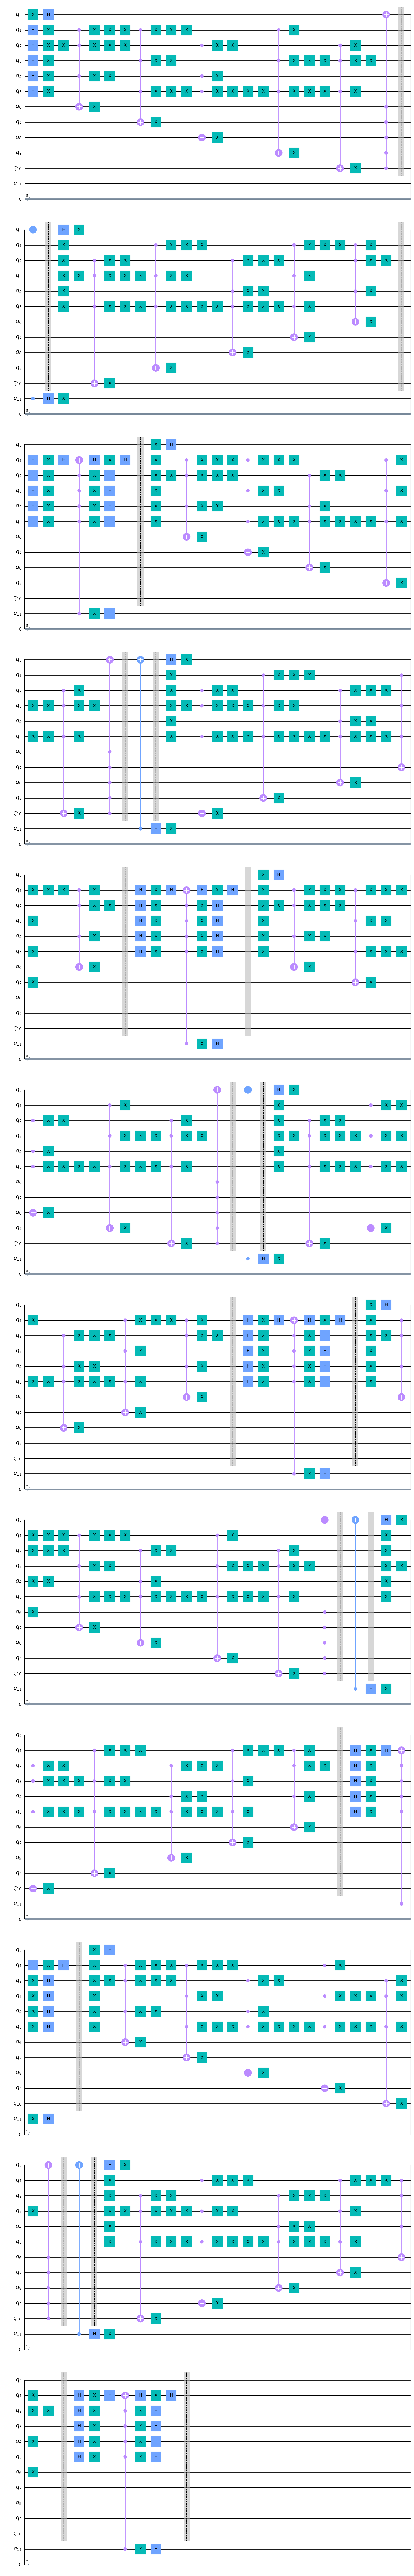

In [972]:
examp="x1 | -x2 |x4 & x5 |x3|-x1 & x4| x2|-x5 & x3 |x1 | -x5 & x2 |x5 | -x3"
gv=main_call(examp)
gv.draw('mpl')


The following are the measurements outcomes for our example.

In [973]:

n=-1
l=parse(examp)
for l1 in l:
    for i in l1:
        n=max(n,abs(i))
gv.measure([i for i in range(1,n+1)],[i for i in range(n-1,-1,-1)]) # we reversed the bits because qiskit prints in reverse
result = execute(gv, backend).result()


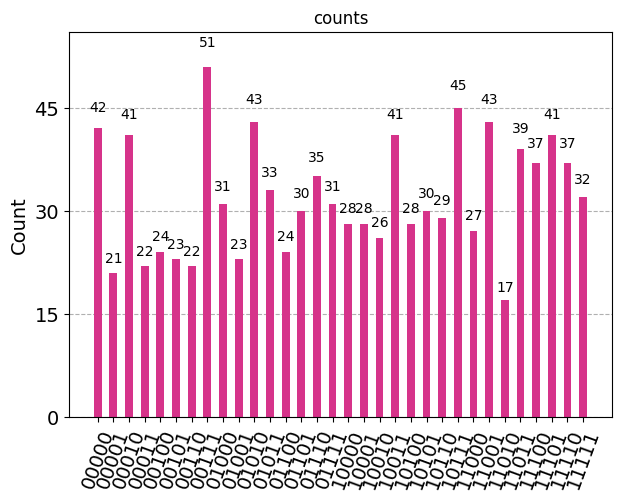

In [974]:

counts = result.get_counts(gv)
plot_histogram(counts, title='counts' , color="#d6338a")

The below extracts one of the $SAT$ assignment with highest amplitude.

In [975]:
#res = counts.most_frequent()
res = max(counts, key=lambda k: counts[k])
print(res)

00111


The above is one of the satisfying assignments.